# Extract image pathces of target from Database query

This notebook extracts an image patch around the target area. It is based on the query images notebook and uses that as a base for locating the target information.

For this notebook to work, you will require a working ArangoDB. See http://localhost:8888/lab/tree/1_import_bagfiles.ipynb for how to set that up.

In [1]:
import numpy as np
import quaternion
import cv2

from scripts.query_image import *

# Parameters
ros_topic_pose = "/gnc/ekf".replace("/", "_")[1:]
ros_topic_image = "/hw/cam_sci/info".replace("/", "_")[1:]

Specify the targets location and size:

In [2]:
# Target Pose
target_position = np.array([-0.84, 0.6, -0.81])
target_attitude = quaternion.from_euler_angles(0, 0, np.radians(180))  # order is roll, pitch, yaw

# Query Contraints
max_distance = 1.0
min_distance = 0.2
max_angle = 30

# Target size, the target is pointed to in the x-axis
target_size_y = 0.05
target_size_z = 0.07

Define the image data folder and where you would like the program to save the extracted image patches. They will have a the same name as the source image with patch:

In [3]:
image_path = 'data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/'
save_path = 'data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/'

## Execute the Query

Query the database for images that contain the target

In [5]:
result = query_image(target_position, target_attitude, ros_topic_pose, ros_topic_image, max_distance, min_distance, max_angle, target_size_y, target_size_z)

Connected to isaac database
From database got 616 matches
From first filtering got 283 matches
Query successful, got 283 matches


Plot a few of the obtained images with the target highlighted

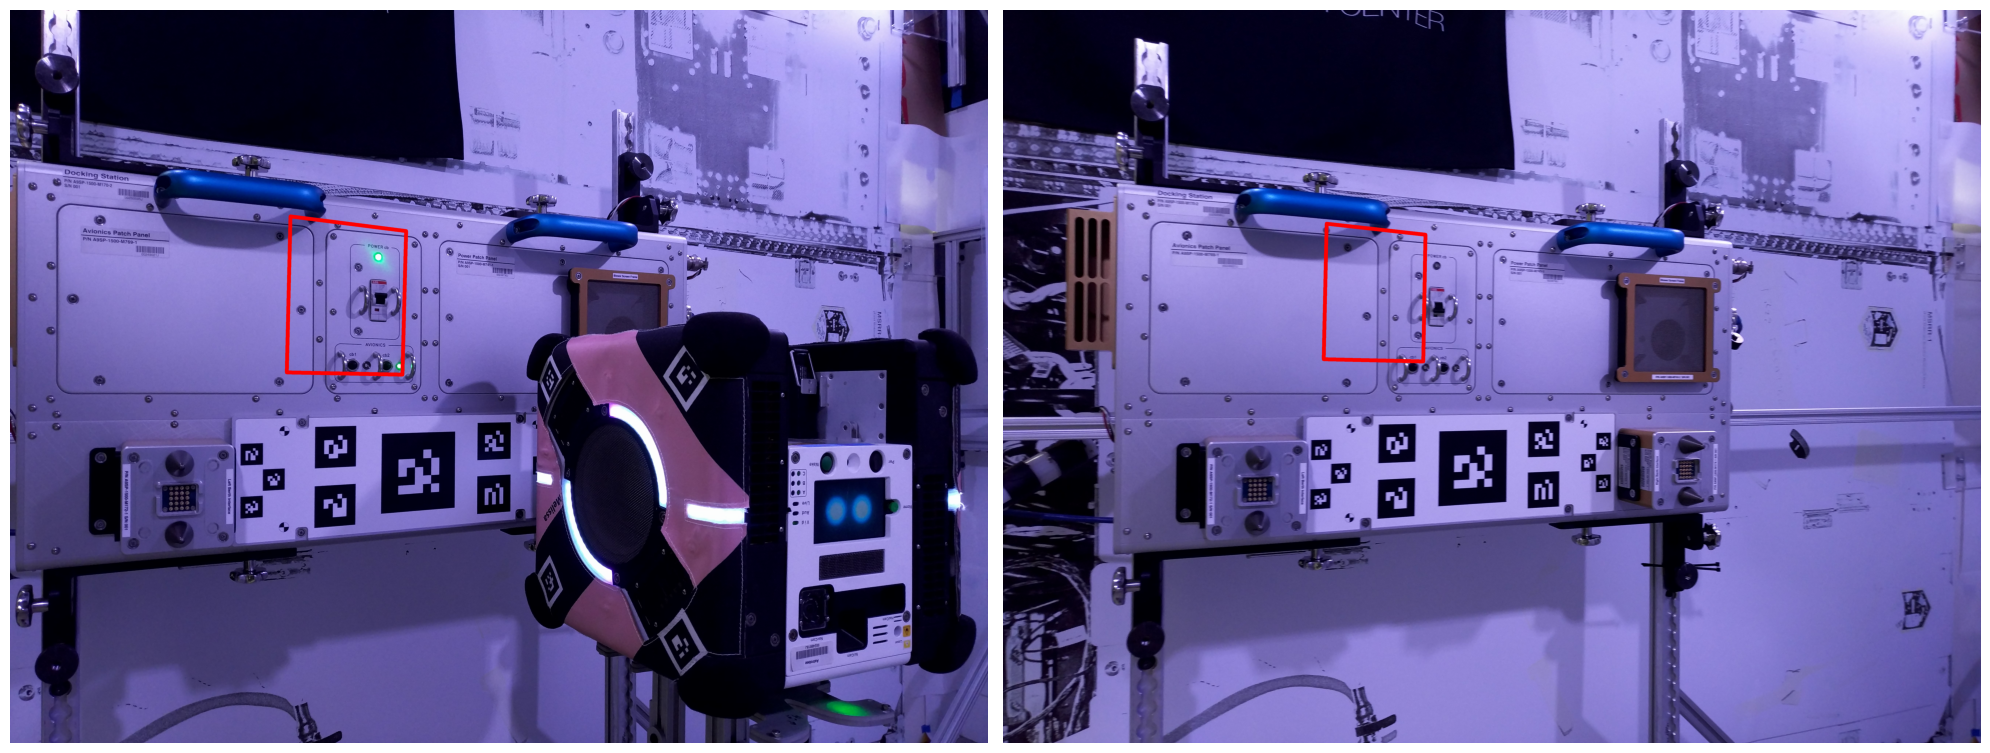

In [5]:
from scripts.plot_query_result import *

max_images = 2
num_columns = 2
fig_size = 20
plot_query_result(result, max_images, num_columns, fig_size)


## Extract the image patch around the target area

First we add a black border around the image. This is incase the target is at one of the edges of the image. The border makes it possible for us to extract an image that is 1000x1200px regardless of were the target is.
The program then makes the target on the first image and shows this to the user. The blue circle in the middle is the coodrinates the image patch extration later in the notebook uses.

In [6]:
b_thickness = 300
i = 0
image = cv2.imread(image_path + result[i]["img"])
plot_image = cv2.copyMakeBorder(src=image, top=b_thickness, bottom=b_thickness, left=b_thickness, right=b_thickness, borderType=cv2.BORDER_CONSTANT) 
plot_image = cv2.circle(plot_image, (result[i]['coord_c1'][0] + b_thickness,result[i]['coord_c1'][1] + b_thickness), radius=50, color=(0, 0, 255), thickness=30) #coord C1 is the left bottom corner
plot_image = cv2.circle(plot_image, (result[i]['coord_c2'][0] + b_thickness,result[i]['coord_c2'][1] + b_thickness), radius=50, color=(0, 0, 255), thickness=30) #coord C2 is the left top corner
plot_image = cv2.circle(plot_image, (result[i]['coord_c3'][0] + b_thickness,result[i]['coord_c3'][1] + b_thickness), radius=50, color=(0, 0, 255), thickness=30) #coord C3 is the right top corner
plot_image = cv2.circle(plot_image, (result[i]['coord_c4'][0] + b_thickness,result[i]['coord_c4'][1] + b_thickness), radius=50, color=(0, 0, 255), thickness=30) #coord C4 is the right bottom corner
plot_image = cv2.circle(plot_image, (result[i]['coord'][0] + b_thickness,result[i]['coord'][1] + b_thickness), radius=50, color=(255, 0, 0), thickness=30)

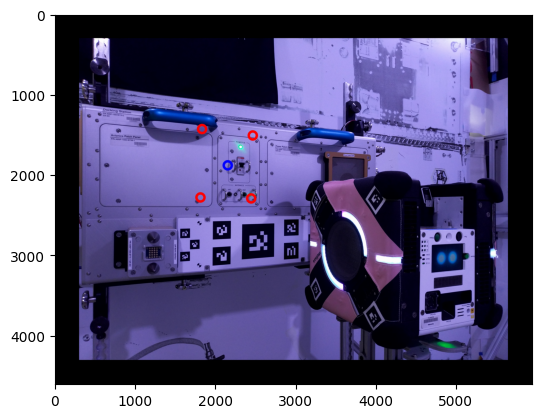

{'coord': [1852, 1584], 'coord_c1': [2144, 1996], 'coord_c2': [2164, 1212], 'coord_c3': [1532, 1132], 'coord_c4': [1512, 1984], 'img': '1711060904.406.jpg'}
[2144, 1996]


In [7]:
plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()
print(result[0]) 
print(result[0]["coord_c1"]) 

In [18]:
def correct_image_perspective(image, corners): #takes the image and the corners in a numpy array as input and returns the image with corrected perspective.
     # Define the perfect square corners
    perfect_square = np.array([[0, 0], [0, 500], [500, 500], [500, 0]], dtype=np.float32)

    # Convert the corner points to numpy array
    corners = np.array(corners, dtype=np.float32)

    # Calculate the perspective transformation matrix
    M = cv2.getPerspectiveTransform(corners, perfect_square)

    # Apply the perspective transformation to the image
    corrected_image = cv2.warpPerspective(image, M, (700, 500))  # Adjust the size as needed

    corrected_image = np.transpose(corrected_image, (1,0,2))

    return corrected_image


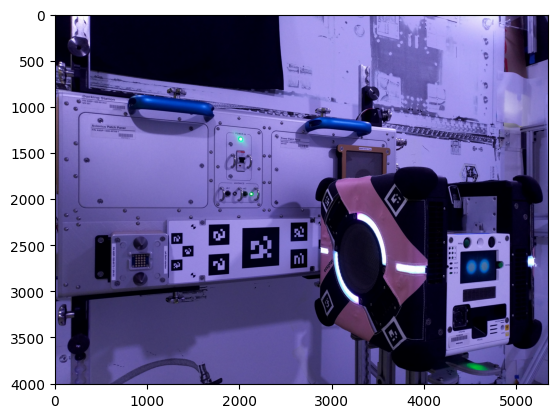

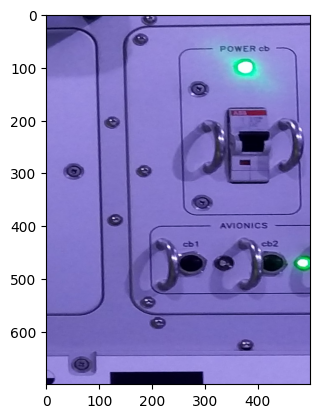

In [19]:
i=0
image = cv2.imread(image_path + result[i]["img"])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

corners = [[result[i]["coord_c3"][0],result[i]["coord_c3"][1]], 
           [result[i]["coord_c2"][0],result[i]["coord_c2"][1]],
           [result[i]["coord_c1"][0],result[i]["coord_c1"][1]],
           [result[i]["coord_c4"][0],result[i]["coord_c4"][1]]]

corrected_image = correct_image_perspective(image, corners)

plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

In [ ]:
#plt.imshow(cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
#plt.show()

In [27]:
for idx, element in enumerate(result):
    image = cv2.imread(image_path + element["img"])
    
    corners = [element["coord_c3"],element["coord_c2"],element["coord_c1"],element["coord_c4"]]

    corrected_image = correct_image_perspective(image, corners)

    
    print('Extracted patch from image "'+ element['img'] + '" in directory (' + image_path + ') and saved it as ' + '"patch_' + element['img'] + '" in directory (' + save_path + ')\n')
    
    #print(i)
    cv2.imwrite(save_path + 'patch_' + element['img'], corrected_image)

print('Done extracting and saving image patches')

Extracted patch from image "1711060904.406.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711060904.406.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)

Extracted patch from image "1711061120.602.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711061120.602.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)

Extracted patch from image "1711061318.832.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711061318.832.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)

Extracted patch from image "1711060905.115.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711060905.115.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)

Extracted patch 

The code below goes through all of the images that resulted from the query done on the datebase. It then adds the border and extracts a 1000x1200px patch around the middle of the target. This image patch  is then saved to the defined "save_path".

In [9]:
b_thickness = 300
for i in range(len(result)):
    image = cv2.imread(image_path + result[i]["img"])

    #image = cv2.copyMakeBorder(src=image, top=b_thickness, bottom=b_thickness, left=b_thickness, right=b_thickness, borderType=cv2.BORDER_CONSTANT) #adding border to allow for extraction when the target is detected at the edges
    img_patch = image[result[i]['coord'][1]-600+b_thickness:result[i]['coord'][1]+600+b_thickness, result[i]['coord'][0]-500+b_thickness:result[i]['coord'][0]+500+b_thickness] #extracting the image patch (1000x1200px), compensating for the added border
    
    
    print('Extracted patch from image "'+ result[i]['img'] + '" in directory (' + image_path + ') and saved it as ' + '"patch_' + result[i]['img'] + '" in directory (' + save_path + ')')
    
    #print(i)
    cv2.imwrite(save_path + 'patch_' + result[i]['img'], img_patch)

Extracted patch from image "1711060904.406.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711060904.406.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)
Extracted patch from image "1711060904.406.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711060904.406.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)
Extracted patch from image "1711061120.602.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711061120.602.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)
Extracted patch from image "1711061318.832.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/isaac_sci_cam_image_delayed/) and saved it as "patch_1711061318.832.jpg" in directory (data/bags/2024-03-21_tim/bsharp/Fixed/extracted_patches/)
Extracted patch from